# Observibility for Sequential Multi-Agent Travel Assistant with LangGraph

## Table of Contents
- [Introduction](#introduction)
- [Prerequisites](#prerequisites)
- [Setup](#setup)
- [Creating and Tracing Your First Agent](#Tracing-Your-First-Agent-in-Sagemaker-MLFlow)
- [Add Custom tracing for Agents](#Add-More-Agents-and-tracing-it-with-MLFlow-custom-decorators)
- [Enhance Agent Capabilities Using Tools](#enhance-agent-capabilities-using-tools)

## Introduction

**Sagemaker MLflow** is a versatile, built using the open-source platform for managing workflows and artifacts across the machine learning and generative AI lifecycle. It has built-in integrations with many popular AI and ML libraries, but can be used with any library, algorithm, or deployment tool.

MLflow's LangChain integration provides the following capabilities:

- Tracing: Visualize data flows through your LangChain components with one line of code (mlflow.langchain.autolog())
- Experiment Tracking: Log artifacts, code, and metrics from your LangChain runs
- Model Management: Version and deploy LangChain applications with dependency tracking
- Evaluation: Measure the performance of your LangChain applications

**LangGraph** is an extension of LangChain that provides a framework for building stateful, multi-agent applications. This notebook demonstrates how to create a travel assistant using multi-agent collaboration with LangGraph. Specifically, you will use this assistant to generate articles on the top activities and attractions for a specific location.

To learn more about SageMaker MLFlow with agentic application see AWS blog - [Advanced tracing and evaluation of generative AI agents using LangChain and Amazon SageMaker AI MLFlow](https://aws.amazon.com/blogs/machine-learning/advanced-tracing-and-evaluation-of-generative-ai-agents-using-langchain-and-amazon-sagemaker-ai-mlflow/)

**Estimated completion time:** 30-45 minutes

### Objectives

By the end of this notebook, you will:
1. Learn how to enable detailed tracing for LangGraph agent using Sagemaker
2. Implement and observe a multi-agent system that can research, write, use tools and edit travel content

### Structure of the Travel Assistant agent

We will use a travel assistant agent as an example and this notebook provides step-by-step guidance for creating a travel assistant consisting of the following agents:

```mermaid
graph LR
    User[User Query] --> A[Researcher Agent]
    A --> B[Content Writer Agent]
    B --> C[Editor Agent]
    C --> D[Final Article]
    
    style A fill:#f9d5e5,stroke:#333,stroke-width:2px
    style B fill:#eeac99,stroke:#333,stroke-width:2px
    style C fill:#e06377,stroke:#333,stroke-width:2px
    style D fill:#c83349,stroke:#333,stroke-width:2px
```

1. **Researcher Agent** - Responsible for gathering information on the top 5 attractions and activities in a specific location
2. **Content Writer Agent** - Responsible for writing an engaging article based on the information of the top 5 attractions
3. **Editor Agent** - Responsible for improving the flow and language use within the article

## Prerequisites

Before starting this notebook, ensure you have:
- Basic understanding of Python and Jupyter notebooks
- AWS account with access to Amazon Bedrock and SageMaker
- Tavily API key (for web search functionality)
- Familiarity with LangChain concepts (optional but helpful)
- If this is run as part of the AWS workshop, ensure previous section of the workshop labs are complete.
- Access to AWS Account, and SageMakerAI Studio. See [AWS instructions here](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html) if you want to get started with SageMakerAI Studio quickly.
- Setup and launch **SageMakerAI MLFlow**. See [AWS instructions here](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-launch-ui.html) 
- See below for a sample IAM policy which the IAM role will need to use SageMaker MLFLow (Like for tracing). For more on SageMaker MLFlow's IAM details see [AWS IAM documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-create-tracking-server-iam.html)

```
{
    "Version": "2012-10-17",    
    "Statement": [        
        {            
            "Effect": "Allow",            
            "Action": "sagemaker-mlflow:*",            
            "Resource": "*"        
        }        
    ]
}
```

- You will need to note down the `SageMaker MLFlow tracing server ARN` and use it in the notebooks. You can quickly copy the ARN on sagemakerAI studio by clicking the copy icon on you MLFlow 

---

## Setup

Start by installing some of the required packages, including LangChain for pre-built tool components, LangGraph for agent workflows, and other necessary libraries. Similar as the `langgraph-requirements.txt` from the previous lab.

In [ ]:
%%writefile langgraph-requirements.txt
boto3
botocore
sagemaker
langchain
langchain_aws
langchain_experimental
langgraph
matplotlib

In [ ]:
%pip install -r langgraph-requirements.txt -qU
%pip install sagemaker-mlflow mlflow --upgrade --quiet

<div class="alert alert-block alert-info">
<b>Important:</b> restart the kernel before proceeding with the next cells.
</div>

## SagemakerAI MLFlow
We will configure MLflow integration with Amazon SageMaker for tracking and tracing agent-based workflows. Frist we establishes a connection to a specific SageMakerAI MLflow Tracking Server using an ARN (Amazon Resource Name). 
The `mlflow.set_tracking_uri()` method directs all subsequent MLflow logging operations to this server, ensuring experiment metadata is stored in the secure backend maintained by SageMaker.

Importantly, `mlflow.langchain.autolog()` activates automatic logging of LangChain components, capturing chain executions, prompts, LLM calls, and other interactions without requiring manual instrumentation. This configuration enables comprehensive tracking of ML experiments with minimal additional code, allowing data scientists to focus on their workflows while maintaining detailed logs for later analysis and reproducibility.

The import of `SpanType` from MLflow entities enables detailed tracing of agent workflows, allowing the categorization of different operation types (agent actions, tool calls, LLM invocations) in the execution tree. 

(Optional) You can organize all your MLFlow observibility data by setting `mlflow.set_experiment("<YOUR_MLFLOW_EXPERIMENT_NAME>")`. Using which MLflow allows you to group runs under experiments, which can be useful for comparing runs intended to tackle a particular task.

In [ ]:
import mlflow
from mlflow.entities import SpanType

_MLFLOW_URI = "<YOUR-SAGEMAKERAI-MLFLOW-ARN>" # Replace this field with your Sagemaker MLFlow ARN
mlflow.set_tracking_uri(_MLFLOW_URI)
# enable automatic logging of traces (Optional)
mlflow.langchain.autolog()

### Import and configure LLM model

In [ ]:
from langchain_aws import ChatBedrock, SagemakerEndpoint
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import boto3
import os
import getpass
import json
from textwrap import dedent
from typing import Literal

Now import all of the packages you will need for this lab. This includes the packages described above, as well as textwrap for keeping the prompts readable within the notebook, and typing for type annotations.

Follow the instructions in [this lab](https://catalog.workshops.aws/building-agentic-workflows/en-US/sagemaker) to create a SageMaker real-time endpoint hosting the [DeepSeek R1 Distill-Llama 8B](https://huggingface.co/deepseek-ai/DeepSeek-R1) model. Although you will use this specific model for this lab, LangGraph also supports other models hosted through [Amazon SageMaker](https://docs.crewai.com/concepts/llms#amazon-sagemaker) or [Amazon Bedrock](https://docs.crewai.com/concepts/llms#aws-bedrock). While the SageMaker endpoint is being created, you can copy the name of the endpoint and replace the text `INSERT ENDPOINT NAME` in the code below with the endpoint name.

When setting up an LLM model, you can also set model parameters. In this case, we set `temperature` to 0.7 to balance creativity with accuracy. A higher temperature (closer to 1.0) would produce more creative but potentially less accurate responses, while a lower temperature (closer to 0) would produce more deterministic responses.

In [ ]:
model = ChatBedrock(
    model="us.amazon.nova-pro-v1:0",
    temperature=0.7,
    region="us-west-2"
)

-----

## Create Your First Agent

Let's start by creating the first agent - the researcher agent. This agent will be responsible for gathering information on the top 5 attractions and activities for a specific location. 

> **Note:** We'll start simple by creating an agent which relies on the LLM's internal knowledge of various locations around the world. At a later stage, this agent can be extended by providing access to a web search tool.

### Understanding Agent Creation in LangGraph

In LangGraph, agents are created using the `create_react_agent` function, which implements the ReAct (Reasoning and Acting) pattern. This pattern allows the agent to reason about its actions and then execute them in an iterative process.

In [ ]:
# Define the Agent
research_agent = create_react_agent(
    model=model,
    tools=[],
    prompt=dedent(
            """You are an experienced travel researcher with a knack for 
            discovering both popular attractions and hidden gems in any 
            location. Your expertise lies in gathering comprehensive 
            information about various activities, their historical 
            significance, and practical details for visitors. Research and 
            compile a list of at least 5 interesting activities and 
            attractions in the requested location. Include a mix of popular tourist 
            spots and lesser-known local favorites. For each item, provide:
            1. Name of the attraction/activity
            2. Brief description (2-3 sentences)
            3. Why it's worth visiting
            Your final answer should be a structured list of these items.
            """
    ),
)

### Creating a Node

Next, you will create a task using LangGraph Node. 

In [ ]:
# Define the Node (task)

def research_node(state: MessagesState):
    result = research_agent.invoke(state)
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto="content_writer",
    )

### Creating Your First Graph

Now you can create your first graph. In LangGraph, a **StateGraph** represents the entire workflow, with nodes connected by edges that define the flow of execution.

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)

workflow.add_edge(START, "researcher")
# workflow.add_edge("researcher", END)
graph = workflow.compile()

### Tracing Your First Agent in Sagemaker MLFlow 

Now you can trace your first agent in your sagemaker MLFlow!

**Expected Output:**
You should see the agent's traced in sagemaker MLFlow UI with inputs, outputs, and internal trace metadata information like number to tokens used (a.k.a cost).

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Write a listicle for Amsterdam, Netherlands."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

# Ignore warnings

### Open you SageMaker MLFlow UI and see the tracing tab to the outputs
- Expand the "Oputput" section on the right side to view details of the metadata information
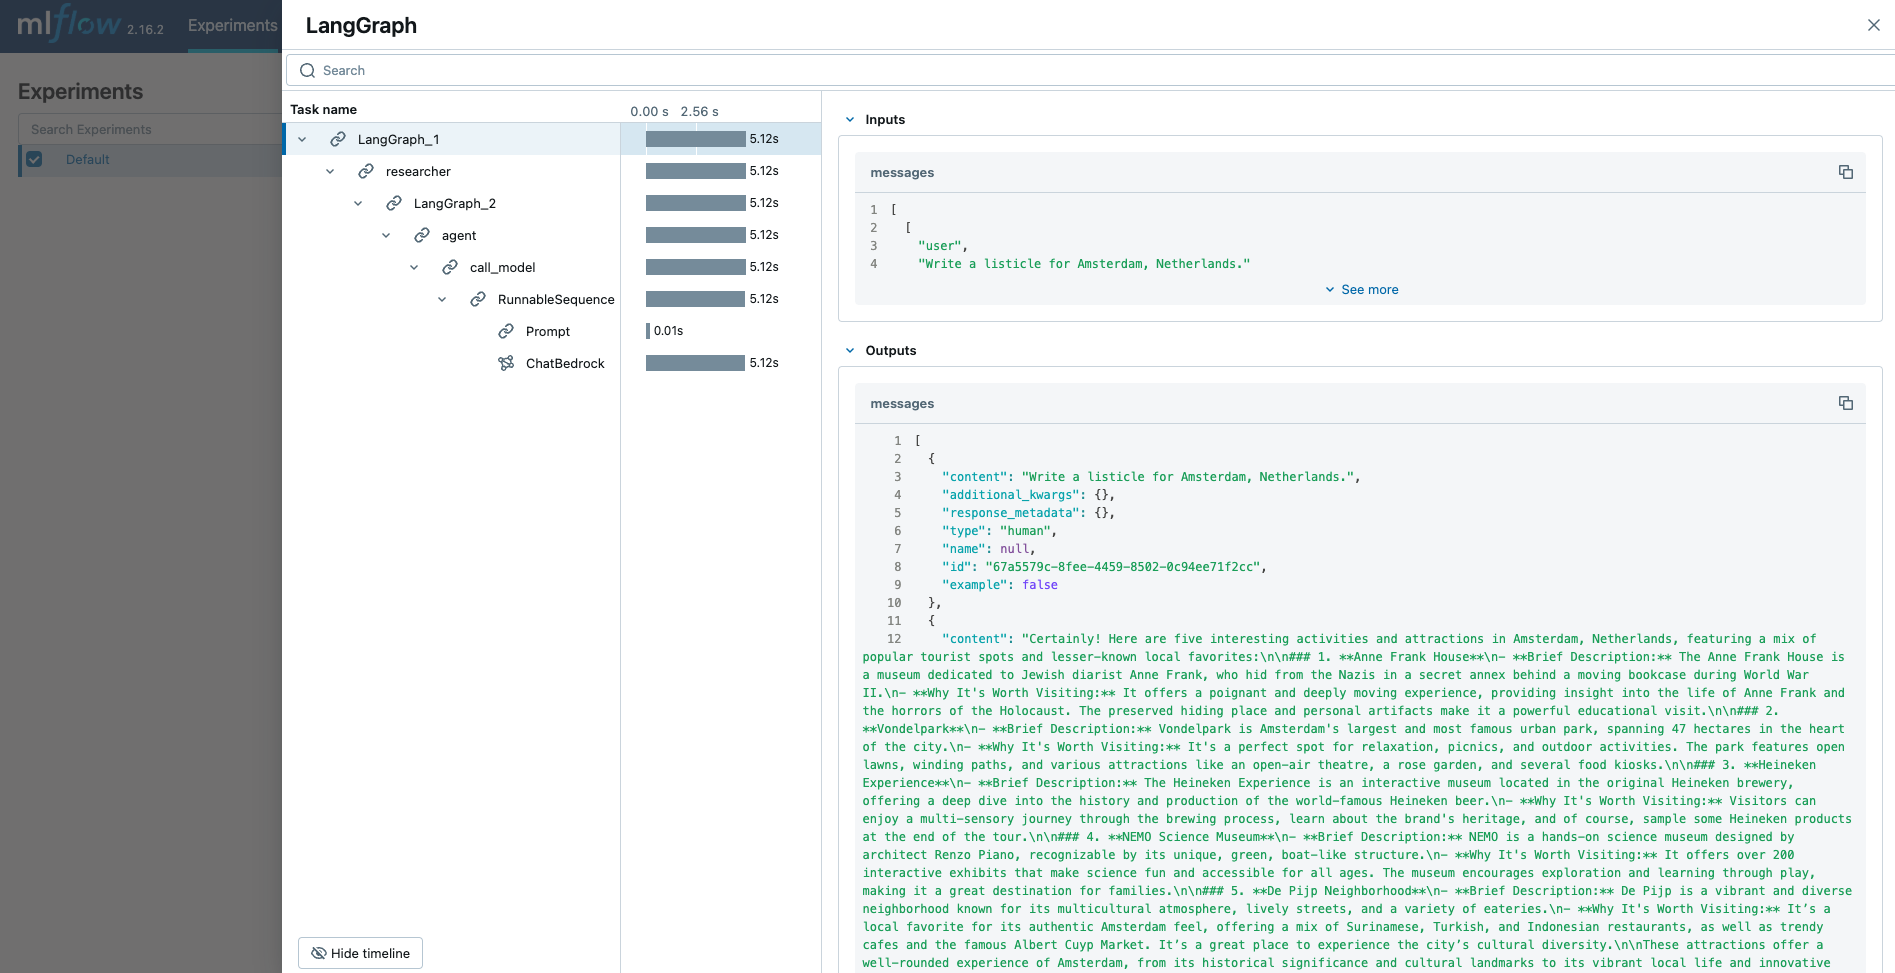

----

## Add More Agents and tracing it with MLFlow custom decorators

Next, you will create a second agent using LangGraph Node and introduce MLFlow's custom decorators `@mlflow.trace()`. 
While you can trace without the decorator, this custom decorators tracing configuration is particularly useful for performance analysis and debugging multi-agent orchestration systems. When applied to functions representing agent operations it provides two important capabilities:
- Setting `span_type=SpanType.AGENT` tells MLflow that this span represents an agent's activity within your workflow. When visualized in MLflow's tracing UI, spans with this type will be categorized and displayed distinctly from other operation types (like tools or LLM calls). Different types of span are: `SpanType.TOOL` A tool call (e.g., Google Search), `SpanType.LLM` An LLM model invocation (e.g., generating text) and `SpanType.CHAIN` A sequence of steps (e.g., the whole pipeline).
- The `attributes={"workflow": "agent_tool_search"}` parameter adds a custom metadata tag to the span. These custom attributes are extremely valuable when you have complex multi-agent systems with Associate spans with: specific workflow components, Filter traces by workflow stage during debugging, Add domain-specific metadata to your traces

When applied this decorator would track:
- Input: The user's query from the Streamlit app
- Processing: Time spent on analysis
- Tool usage: Web search calls (which would appear as child spans)
- Output: The research results passed to Agent 2

This tracing configuration is particularly useful for performance analysis and debugging custom logic or other orchestration systems.


In [ ]:
content_writer_agent = create_react_agent(
    model,
    tools=[],
    prompt=dedent(
            """You are a skilled travel writer with a flair for creating 
            captivating content. Your writing style is engaging, 
            informative, and tailored to inspire readers to explore new 
            destinations. You excel at crafting concise yet compelling 
            descriptions of attractions and activities. Create an engaging 
            top 5 listicle article about things to do in the requested location. 
            Use the research provided to:
            1. Write a catchy title and introduction (100-150 words)
            2. Select and write about the top 5 activities/attractions
            3. For each item, write 2-3 paragraphs (100-150 words total)
            4. Include a brief conclusion (50-75 words) 
            Ensure the content is engaging, informative, and inspiring. 
            Your final answer should be the complete listicle article.
            """
    ),
)


@mlflow.trace(attributes={"workflow": "agent_writer_node"}, span_type=SpanType.AGENT)
def writer_node(state: MessagesState) -> Command[Literal["content_editor"]]:
    result = content_writer_agent.invoke(state)
    return Command(update={"messages": result["messages"]}, goto="content_editor")

### Editor Agent

Professional media companies employ editors to improve the quality of articles. By taking a second look at a good article, we can make it great. So let's create a third agent which specializes in editing existing articles to improve the flow of the story and improve readability.

In [ ]:
from langgraph.graph import END

content_editor_agent = create_react_agent(
    model,
    tools=[],
    prompt=dedent(
            """You are a meticulous editor with years of experience in 
            travel content. Your keen eye for detail helps polish articles 
            to perfection. You focus on improving flow, maintaining 
            consistency, and enhancing the overall readability of the 
            content while ensuring it appeals to the target audience. 
            Review and edit the top 5 listicle article about things to 
            do in the requested location. Focus on: 
            1. Improving the overall structure and flow 
            2. Enhancing the engagement factor of the content 
            3. Ensuring consistency in tone and style 
            4. Correcting any grammatical or spelling errors 
            Do not change the content itself. Only edit it for higher quality. 
            Your final answer should be the polished, publication-ready 
            version of the article.
            """
    ),
)


@mlflow.trace(attributes={"workflow": "agent_writer_node"}, span_type=SpanType.AGENT)
def editor_node(
    state: MessagesState,
) -> Command[Literal[END]]:
    result = content_editor_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    # result["messages"][-1] = HumanMessage(
    #     content=result["messages"][-1].content, name="content_editor"
    # )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=END,
    )

### Connecting the Agents in a Sequential Workflow

After creating your second and third agent, you will need to add them both to your team. Tasks can be executed sequentially (i.e., always in the order which they are defined) or hierarchically (i.e., tasks are assigned based on agent roles). 

In this case, the process for writing a travel article is always the same, so we will use a sequential workflow where:
1. The researcher gathers information
2. The writer creates an article based on that information
3. The editor polishes the final article

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("content_writer", content_writer_agent)
workflow.add_node("content_editor", content_editor_agent)

workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "content_writer")
workflow.add_edge("content_writer", "content_editor")
workflow.add_edge("content_editor", END)
graph = workflow.compile()

### Testing the Complete Workflow

Next, test your crew again using the same location as before, such as Amsterdam. You should see the agents executing the tasks in order, resulting in an article about the top 5 attractions for your location.

**Expected Output:**
You should see the output from all three agents in sequence:
1. The researcher's list of attractions
2. The writer's draft article
3. The editor's polished final article

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Write a listicle for Amsterdam, Netherlands.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

#### See the trace output in the SagemakerAI MLFlow UI
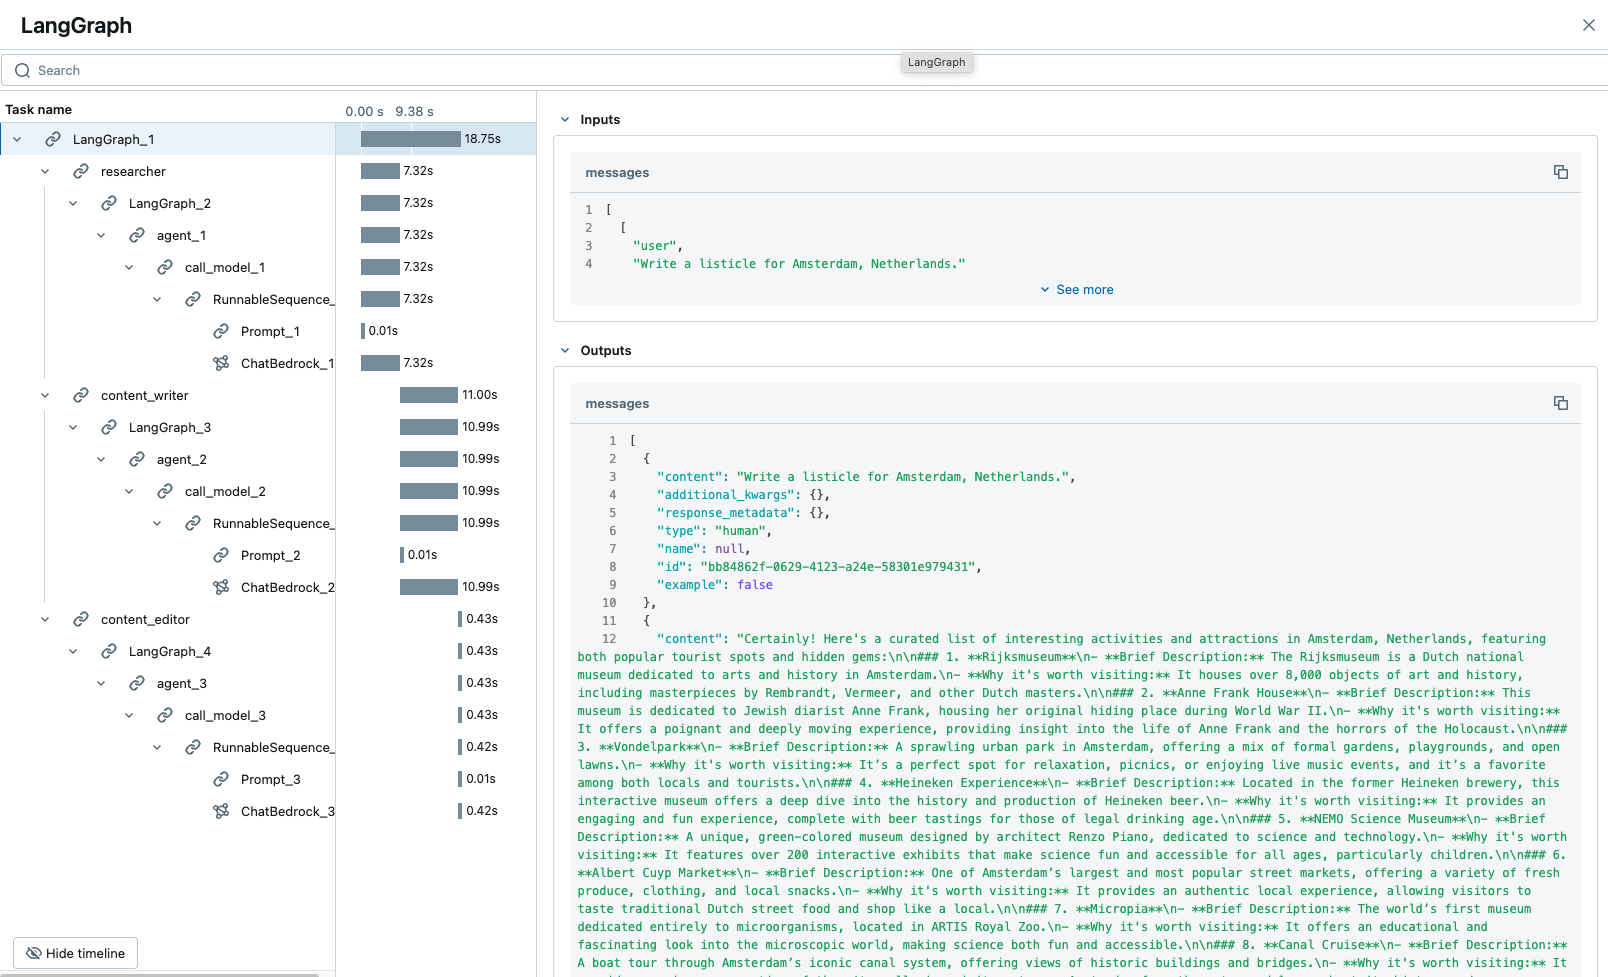

### Testing with a Less Well-Known Location

What happens if you are looking for travel advice for a less well-known location? A model is unlikely to know much about a small village like Hoenderloo, Netherlands (population of ~1,500), even though it has a lot to offer. In this case, the model will likely give recommendations outside of the location itself, or it may even hallucinate attractions which don't exist.

**Expected Output:**
See the trace in SagemakerAI MLFlow UI. You may notice that the model struggles with this less-known location, potentially providing inaccurate or generic information. This highlights the limitations of relying solely on the model's internal knowledge.

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Write a listicle for Hoenderloo, Netherlands.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

----

## Enhance Agent Capabilities Using Tools

Let's extend the capabilities of the research agent by giving it access to a web search tool so it can search for relevant information about a less well-known location.

### Setting Up the Search Tool

There are many API search tools available. LangChain has built-in tools for various search providers. For this notebook, we'll use the Tavily search API, which offers a limited number of free queries. 

> **Note:** To complete this section, you will need to [register with Tavily](https://tavily.com/) and fetch an API key for this service.

In [ ]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("TAVILY_API_KEY")

Now you can instantiate the Tavily search tool. The tool can perform specific searches for news, scholarly articles, images, and more, but in this case you will use the tool to perform a generic internet search. It is recommended to set the maximum number of search results using the `max_results` parameter.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

### Choosing the Right Model for Tool Use

DeepSeek R1 does not natively support function calling or structured outputs ([source](https://github.com/deepseek-ai/DeepSeek-R1/issues/9#issuecomment-2604747754)). With careful prompting it is possible to call a tool with DeepSeek R1, but we recommend choosing the right model for the right job. 

In this case, let's replace the LLM for the researcher agent with [Mistral Large 2402](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-mistral.html), which has better support for tool use. The writer and editor agents will continue to use the DeepSeek model since they don't need to use tools.

Although you can deploy Mistral models on SageMaker endpoints, let's try using Mistral via Amazon Bedrock serverless endpoints instead.

In [ ]:
function_calling_model = ChatBedrock(
    model="mistral.mistral-large-2402-v1:0",
    temperature=0,
    region="us-west-2"
)

### Recreating the Researcher Agent with Tool Access

Recreate the researcher agent to include the tool. In addition to adding the tool in the `tools` parameter, we'll keep the same prompt but now the agent will have access to the search tool.

In [ ]:
research_agent = create_react_agent(
    function_calling_model,
    tools=[tavily_tool],
    prompt=dedent(
            """You are an experienced travel researcher with a knack for 
            discovering both popular attractions and hidden gems in any 
            location. Your expertise lies in gathering comprehensive 
            information about various activities, their historical 
            significance, and practical details for visitors. Research and 
            compile a list of at least 5 interesting activities and 
            attractions in the requested location. Include a mix of popular tourist 
            spots and lesser-known local favorites. For each item, provide:
            1. Name of the attraction/activity
            2. Brief description (2-3 sentences)
            3. Why it's worth visiting
            Your final answer should be a structured list of these items.
            """
    ),
)

You can also re-create the task and edit the prompt slightly to ensure that the model knows it can use the web search tool.

In [ ]:

@mlflow.trace(attributes={"workflow": "agent_research_tool_node"}, span_type=SpanType.AGENT)
def research_node(state: MessagesState) -> Command[Literal["content_writer"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto="content_writer",
    )

### Recreating the Complete Workflow

Recreate the crew with your new research agent. No adjustment is needed for this code.

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("content_writer", content_writer_agent)
workflow.add_node("content_editor", content_editor_agent)

workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "content_writer")
workflow.add_edge("content_writer", "content_editor")
workflow.add_edge("content_editor", END)
graph = workflow.compile()

### Testing the Enhanced Workflow

Now let's test the new crew of agents by asking for travel advice for Hoenderloo. Feel free to test with your location of choice.

**Expected Output:**
With the search tool enabled, you should now see much more accurate and detailed information about Hoenderloo, as the researcher agent can search the web for current and factual information rather than relying solely on the model's internal knowledge.

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Write a listicle for Hoenderloo, Netherlands.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

### Open you SageMaker MLFlow UI and see the tracing tab to the outputs
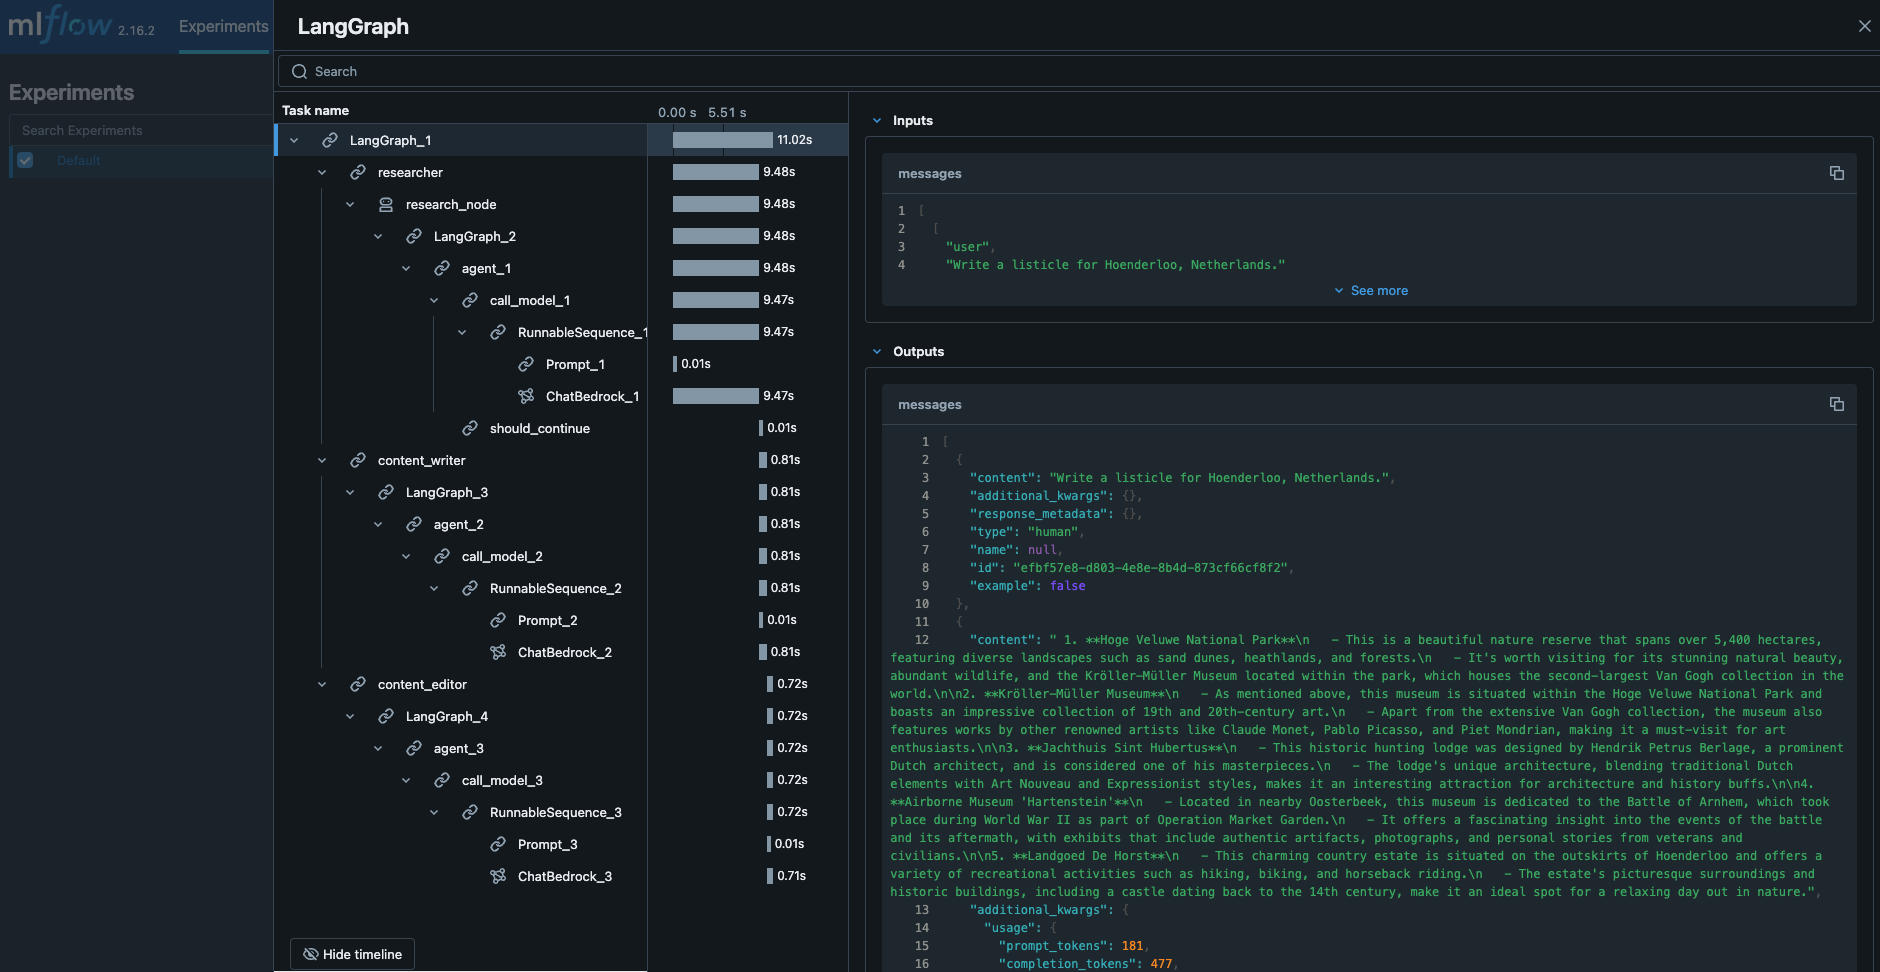

---

## Summary

In this notebook, you've learned how to:

1. Enable observibility for agents using SageMaker MLFlow
2. Add SageMaker MLFlow tracing for langraph agent
3. Create and trace a sequential multi-agent langgraph workflow using Sagemaker MLFlow